# Adapt Motor Imagery classifier (loop) with confidence scores
Use this clean notebook to create the code to update the MI classifier using confidence scores created from Error-related Potentials (ErrPs) and Default Mode Network (DMN) activity / attention. This notebook differs from `Adapt_MI_Decoder_Loop` in that it automatically creates all the decoders without you having to move files around (hide all files ahead of run of interest).

Please see `Check_BCI_ErrP_with_Attention.ipnyb` for a version of this code with plotting / checks / tinkering

Nile Wilson 2019.02.06

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from scipy.fftpack import fft, ifft
from scipy import signal
from mne.filter import filter_data

import scipy.signal as scisig
import numpy as np
import pandas as pd
import datetime
import pickle
import glob
import csv
import mne

## Variables to Set

In [2]:
# Load in the BCI data
subjID = '9d4921'
subject_group = 2
session_number = 2
EEGdevice = 8 # 7 for DSI-7, 8 for Enobio

In [3]:
# Load latest model and its associated data
BCI_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/*' + subjID + '_BCI.easy')
num_of_runs = len(BCI_files)

In [4]:
# Check that this is correct
print('Detected number of BCI runs: ' + str(num_of_runs))

Detected number of BCI runs: 5


## Function Definitions

Functions for working with the BCI data

In [5]:
def FindBCIFiles(subjID, session_number, run_number):
    """
    Returns the file names for the BCI run of choice
    """
    # Load latest model and its associated data
    BCI_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/*' + subjID + '_BCI.easy')
    
    # Throw exception if model number is outside range of existing models
    if run_number-1 > len(BCI_files):
        raise ValueError('Please select a valid run number')
    
    filename_eeg = BCI_files[run_number-1]
    print('Selecting BCI EEG file: ' + filename_eeg)

    behavioral_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/BCI_' + subjID + '*.csv')
    filename_behavioral = behavioral_files[run_number-1]
    print('Selecting BCI behavioral file: ' + filename_behavioral)
    
    return filename_eeg, filename_behavioral

In [6]:
def LoadEEGData(filename, EEGdevice):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    if EEGdevice == 7:
        x = 1
    elif EEGdevice == 8:
        # Read in the .easy file
        df = pd.read_csv(filename, delimiter='\t', header=None)

        # Get metadata from the .info file
        fname = filename[:-5] + '.info'
        with open(fname) as f:
            content = f.readlines()
        content = [x.strip() for x in content]

        # Get the channel names
        channel_info = [x for x in content if 'Channel ' in x]
        channel_names = []
        for ch in range(len(channel_info)):
            channel_names.append(channel_info[ch].split(': ')[1])

        channel_names.append('X')
        channel_names.append('Y')
        channel_names.append('Z')
        channel_names.append('STI 014')
        channel_names.append('DateTime')

        # Get sampling rates
        sampling_rates = [x for x in content if 'sampling rate: ' in x]
        fs_all = []
        for freq in range(len(sampling_rates)):
            tmp = sampling_rates[freq].split(': ')[1].split(' ')[0]
            if tmp in ['N/A']:
                print('Skipping N/A')
            else:
                fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

        # Store sampling rates
        fs = fs_all[0]
        fs_accel = fs_all[1]

        # Assign the column names
        df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

In [7]:
def LoadBehavioralDataBCI(filename_behavioral):
    """
    This function loads behavioral data for the motor screening task and formats it to use in this script
    """
    behavioralData = pd.read_csv(filename_behavioral, ',')
    
    return behavioralData

In [8]:
def SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData):
    """
    This function returns the indices for events of interest
    """
    
    if EEGdevice == 7:
        print('Put code here')
    elif EEGdevice == 8:
        # Store where the values in trigger are equal to 8 (the audio trigger input channel number)
        index_trigger = np.where(EEGdata['STI 014']!=0)
        index_trigger = index_trigger[0]

        # Number of trials is greater than number of total pulses sent
        # 999 when the task ends
        move_left_starts = np.where(EEGdata['STI 014'] == 1)[0]
        move_right_starts = np.where(EEGdata['STI 014'] == 2)[0]
        rest_starts = np.where(EEGdata['STI 014'] == 3)[0]
        rest_ends = np.where(EEGdata['STI 014'] == 4)[0]
        
        # If the number of rest_starts and rest_ends don't match, drop the extra one
        # there should, by default, only be 12 starts and 12 ends

        if len(rest_ends) > len(rest_starts):
            if rest_ends[0] < rest_starts[0]:
                rest_ends = rest_ends[1:]
        elif len(rest_ends) < len(rest_starts):
            if rest_ends[0] > rest_starts[0]:
                rest_starts = rest_starts[1:]
        
        move_starts = np.sort(np.concatenate((move_left_starts,move_right_starts),0))
        total_movements = len(move_starts)

        # exclude movements that occur without defined baseline (if you need to get rid of first rest)
        hasBaseline = list()
        for movement in range(0,len(move_starts)):
            hasBaseline.append(True in (rest_starts < move_starts[movement]))

        np.where(hasBaseline)
        move_starts = move_starts[np.where(hasBaseline)]

        # exclude the move lefts and move rights that were thrown out in move_starts
        for movement in range(0,total_movements):
            if hasBaseline[movement] is False:
                # for the left movements
                idx_left = np.where(move_left_starts == move_starts[movement])
                idx_left = np.asarray(idx_left)
                idx_right = np.where(move_right_starts == move_starts[movement])
                idx_right = np.asarray(idx_right)

                if idx_left.size > 0:
                    move_left_starts = np.delete(move_left_starts, idx_left)
                if idx_right.size > 0:
                    move_right_starts = np.delete(move_right_starts, idx_right)
                
        num_of_trials = len(rest_starts)
        num_of_movements = len(move_left_starts) + len(move_right_starts)
    
    return num_of_trials, num_of_movements, move_starts, hasBaseline, rest_starts, rest_ends

In [9]:
def EpochBCIData(EEGdata, fs, move_starts, rest_starts, rest_ends):
    """
    This function epochs the data
    """
    
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:8]

    epochs = []
    epochs_norm = []

    for movement in range(0,len(move_starts)):
        # Data for this movement
        t_start = move_starts[movement] - np.round(2.00*fs)
        t_end = move_starts[movement] - np.round(0.250*fs)

        # Baseline
        restOfInt = np.max(np.where(rest_starts < move_starts[movement]))
        tb_start = rest_starts[restOfInt]
        tb_end = rest_ends[restOfInt]

        # Note, baseline is filtered before it is used in the live script
        baseline_pre_filt = np.asarray(EEGdata.loc[tb_start:tb_end][channels]) * 1.0
        baseline_filt = filter_data(baseline_pre_filt.T, sfreq=fs, l_freq=7, h_freq=31, verbose='ERROR')
        baseline = baseline_filt.T

        # Filter per epoch, like you would in real-time
        pre_filt = np.asarray(EEGdata.loc[t_start:t_end][channels]) * 1.0
        filtered = filter_data(pre_filt.T, sfreq=fs, l_freq=7, h_freq=31, verbose='ERROR')
        epoch = pd.DataFrame(filtered.T)
        epoch.columns = EEGdata.columns[0:8]

        # Store epoch
        tmp = (epoch - np.mean(baseline))/np.std(baseline)
        tmp = pd.DataFrame(tmp)
        tmp.columns = EEGdata.columns[0:8]

        epochs_norm.append(tmp)
        epochs.append(epoch)

    return epochs, epochs_norm

In [10]:
def OrganizeTrials(behavioralData, hasBaseline):
    """
    Organizes trials
    """
    
    # When target was to the left
    trialL = np.where(behavioralData['target_x'] < 1000)
    
    # When target was to the right
    trialR = np.where(behavioralData['target_x'] > 1000)
    
    # Create a single list that includes which trial is which (L = 0, R = 1)
    trial_type = np.zeros([1,len(behavioralData['score'])])
    trial_type[0][trialL] = 0
    trial_type[0][trialR] = 1

    trial_type = np.round(trial_type[0])
    
    # Remove trials if no baseline
    for movement in range(0,len(hasBaseline)):
        if hasBaseline[movement] is False:
            trial_type = np.delete(trial_type, movement)
            
    return trial_type

In [11]:
def ExtractFeaturesBCI(epochs, num_of_movements, channelsToUse, ds_factor):
    """
    Extract signal features of interest
    """
    
    # Get the summed delta power for each trial
    alpha_power = dict.fromkeys(channelsToUse)
    beta_power = dict.fromkeys(channelsToUse)
    ds_f = ds_factor # downsampling factor

    for chanOfInt in channelsToUse:
        tmp_alpha = list()
        tmp_beta = list()

        for movement in range(0, num_of_movements):
            f, Pxx_den = signal.welch(signal.decimate(epochs[movement][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
            alpha_idx = np.where(np.logical_and(np.round(f) > 8, np.round(f) <= 12))
            tmp_alpha.append(np.sum(Pxx_den[alpha_idx]))

            beta_idx = np.where(np.logical_and(np.round(f) > 13, np.round(f) <= 30))
            tmp_beta.append(np.sum(Pxx_den[beta_idx]))

        alpha_power[chanOfInt] = tmp_alpha
        beta_power[chanOfInt] = tmp_beta
    
    return alpha_power, beta_power

Functions for working with error (ErrPs)

In [12]:
def EpochErrorData(EEGdata, fs, EEGdevice, t_trial_start):
    """
    This function epochs the data
    """
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:8]

    epochs = []

    for trial in range(0,len(t_trial_start)):
        t_start = t_trial_start[trial] - np.round(0  * fs)
        t_end = t_trial_start[trial] + np.round(0.600 * fs)

        # Baseline
        tb_start = t_trial_start[trial] - np.round(0.700 * fs)
        tb_end = t_trial_start[trial] - np.round(0.100 * fs)
        baseline = EEGdata.loc[tb_start:tb_end][channels]

        # Store epoch
        tmp = (EEGdata.loc[t_start:t_end][channels] - np.mean(baseline))/np.std(baseline)
        epochs.append(tmp)
    
    return epochs

In [13]:
def ExtractErrorFeatures(epochs, num_of_trials, error_template, correct_template, featureType):
    """
    Extract signal features of interest
    featureType:    'template' or 'frequency'. 'template' returns features based on the template projection values
                    for individual epochs with the error and correct templates. 'frequency' returns features that
                    are just delta and theta power for each channel for the epochs
    """
    
    if featureType in ['template','Template','TEMPLATE','t','T','projection','Projection','PROJECTION','p','P']:
        # template_projection[chanOfInt] will have two columns
        # col 1: how well the trial signal matches with the error signal template
        # col 2: how well the trial signal matches with the correct signal template
        projections_all = dict()
        channelsToUse = error_template.keys()

        for chanOfInt in channelsToUse:
            projections = np.zeros([2, num_of_trials])
            for trial in range(0, num_of_trials):
                # Individual epoch (normalized)
                tmp = epochs_norm[trial][chanOfInt]
                a = tmp

                # Template waveform for error (normalized)
                tmp0 = error_template[chanOfInt]
                tmp_norm = (tmp0 - np.mean(tmp0))/np.std(tmp0)
                b = tmp_norm

                # Template waveform for correct (normalized)
                tmp = correct_template[chanOfInt]
                tmp_norm = (tmp - np.mean(tmp0))/np.std(tmp0)
                c = tmp_norm

                # Store sum of convolutions

                projections[0][trial] = np.sum(np.convolve(a,b,'same'))
                projections[1][trial] = np.sum(np.convolve(a,c,'same'))

            projections_all[chanOfInt] = projections
        
        # Organize the features
        channels = list(projections_all.keys())
        num_of_features = np.shape(projections_all['Cz'])[0] * len(channels)
        channels_full = list(projections_all.keys()) * 2
        num_of_trials = np.shape(projections_all['Cz'])[1]

        features = np.zeros([num_of_features, num_of_trials])

        for trial in range(0, num_of_trials):
            # Error trials are 0 to num_of_features//2, and correct trials are num_of_features//2 to num_of_features
            for feature in range(0, num_of_features):
                features[feature, trial] = projections_all[channels_full[feature]][0][trial]
            
    elif featureType in ['frequency','Frequency','FREQUENCY','f','F']:
        channelsToUse = error_template.keys()
        delta_power = dict.fromkeys(channelsToUse)
        theta_power = dict.fromkeys(channelsToUse)
        ds_f = 1 # downsampling factor

        for chanOfInt in channelsToUse:
            tmp_delta = list()
            tmp_theta = list()

            for trial in range(0, num_of_trials):
                f, Pxx_den = signal.welch(signal.decimate(epochs_norm[trial][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
                delta_idx = np.where(np.round(f) <= 4)
                tmp_delta.append(np.sum(Pxx_den[delta_idx]))

                theta_idx = np.where(np.logical_and(np.round(f) > 4, np.round(f) <= 7))
                tmp_theta.append(np.sum(Pxx_den[theta_idx]))

            delta_power[chanOfInt] = tmp_delta
            theta_power[chanOfInt] = tmp_theta
            
        # Organize the features
        num_of_examples = len(delta_power['Cz'])
        num_of_features = len(delta_power.keys()) + len(theta_power.keys()) 
        features = np.zeros([num_of_features, num_of_examples])

        # Get all channels in one list to loop through
        feature_channels = np.concatenate([np.asarray(list(delta_power.keys())),np.asarray(list(theta_power.keys()))])

        for i in range(0, num_of_examples):
            for j in range(0, num_of_features//2):
                features[j, i] = delta_power[feature_channels[j]][i]
            for j in range(num_of_features//2, num_of_features):
                features[j, i] = theta_power[feature_channels[j]][i]

    
    return features

In [14]:
def ConfidenceScoreExamples(X, y, EEGdata, epochs_norm, EEGdevice, fs, num_of_movements, move_starts, trial_type):
    """
    This is the function that does the confidence scoring based on error detection and attention
    """
    # Load the error detection model and see what featureType it used (frequency or template projections)
    models = glob.glob('Models/' + subjID + '/Session1/' + subjID + '_Error_classifier_*') #always load session1 error
    model_file = models[-1] # load the most recent model
    clf_error = pickle.load(open(model_file, 'rb'))
    print(model_file)
    print(clf_error)

    models_data_list = glob.glob('Models/' + subjID + '/Session1/' + subjID + '_data_for_Error_classifier_*')
    models_data = models_data_list[-1] # load the most recent model
    loaded_data = np.load(models_data)
    featureType = loaded_data['featureType']
    
    # Load templates if applicable
    error_template = loaded_data['error_template'].tolist()
    correct_template = loaded_data['correct_template'].tolist()

    # Create new epochs for error detection
    epochs = EpochErrorData(EEGdata, fs, EEGdevice, move_starts)
    features = ExtractErrorFeatures(epochs, num_of_movements, error_template, correct_template, featureType)
    features = features.T
    
    # Scale the features
    features = StandardScaler().fit_transform(features)
    
    # Detect error
    preds_error = clf_error.predict(features) # is there an ErrP or not? 1 = yes ErrP, 0 = no ErrP
    preds_error_proba = clf_error.predict_proba(features) # what is the prob of there being an ErrP?
    
    # Confidence in the prediction of error
    prob_error = (preds_error_proba[:,1] * preds_error)

    # Confidence in the prediction of no error
    prob_no_error = preds_error_proba[:,0] * (1-preds_error)
    
    # Get values for attention
    attention_alpha, attention_beta = ExtractFeaturesBCI(epochs_norm, num_of_movements, ['Pz'], 1)
    epochs_rest, epochs_rest_norm = GetRestEpochsBCI(EEGdata, rest_starts, rest_ends)
    attention_alpha_rest_norm, attention_beta_rest_norm = ExtractFeaturesBCI(epochs_rest_norm, len(epochs_rest), ['Pz'], 1)
    beta_threshold = np.mean(attention_beta_rest_norm['Pz'])-(2*np.std(attention_beta_rest_norm['Pz']))
    distance_from_threshold = (attention_beta['Pz']-beta_threshold)/np.max(attention_beta_rest_norm['Pz'])

    # Confidence the epoch is correct
    w_a = 0.5
    CS_pre_scale = ((prob_no_error - prob_error + 1) - (w_a*distance_from_threshold))/2
    CS = (CS_pre_scale - np.min(CS_pre_scale))/(np.max(CS_pre_scale)-np.min(CS_pre_scale))
    
    """
    Also return true label stuff
    """
    # Also return true label scores
    # Load the error detection model and see what featureType it used (frequency or template projections)
    models = glob.glob('Models/' + subjID + '/Session1/' + subjID + '_MI_classifier_*')
    model_file = models[-1] # load the most recent model
    clf_MI = pickle.load(open(model_file, 'rb'))

    preds_MI = clf_MI.predict(X)
    
    # trial_type 0 is L, trial_type 1 is R, and TL 1 is high confidence (correct), and TL 0 is low confidence (error)
    TL = list()
    for trial in range(0, len(trial_type)):
        if trial_type[trial] == 0:
            if preds_MI[trial] == 0:
                TL.append(1)
            else:
                TL.append(0)
        elif trial_type[trial] == 1:
            if preds_MI[trial] == 1:
                TL.append(1)
            else:
                TL.append(0)

    return CS, TL, preds_MI, preds_error, preds_error_proba, epochs, features, clf_error, beta_threshold, attention_beta

In [15]:
def RetrainDecoder(clf, CS, threshold, X_old, y_old, X_new, y_new, adaptationType):
    """
    Retrains the decoder on ALL the previous data plus what you decided to add in with high confidence scores
    
    clf: your preloaded model (most recent version)
    CS: confidence scores (if true labels, use TL instead of CS)
    X_old: your preloaded model data (X)
    y_old: your preloaded model data (y)
    X_new: your new motor features
    y_new: your new labels
    """
    # Concatenate old X and y with new X and y that have a high enough confidence score
    aboveThreshold = np.where(CS>threshold)
    
    X = np.concatenate((X_old, X_new[aboveThreshold]), axis=0)
    y = np.concatenate((y_old, np.asarray(y_new)[aboveThreshold]), axis=0)
    
    # preprocess dataset, split into training and test part
    args = np.arange(len(X))
    np.random.shuffle(args)
    X = [X[i] for i in args]
    y = [y[i] for i in args]
    X_not_scaled = X
    X = StandardScaler().fit_transform(X)
    
    # Resample to account for imbalance introduced by CS thresholding
    method = SMOTE(kind='regular')
    X_balanced, y_balanced = method.fit_sample(X, y)

    # Fit the model
    clf.fit(X_balanced,y_balanced)
    
    return clf, X, X_not_scaled, y

In [16]:
def SaveDecoderAndData(clf, X, X_not_scaled, y, subjID, session_number, adaptationType):
    """
    Save the decoder and the data it was trained/tested on
    """
    time_to_save = datetime.datetime.now().isoformat()
    time_to_save = time_to_save.replace('T','-')
    time_to_save = time_to_save.replace(':','-')
    
    model = clf
    if adaptationType == 'CS':
        model_file = 'Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_' + time_to_save[:19] + '.sav'
        filepath_export_data = 'Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_' + time_to_save[:19] + '.npz'
    elif adaptationType == 'TL':
        model_file = 'Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_TL_' + time_to_save[:19] + '.sav'
        filepath_export_data = 'Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_TL_' + time_to_save[:19] + '.npz'

    pickle.dump(model, open(model_file, 'wb'))
    np.savez_compressed(filepath_export_data, X=X, X_not_scaled=X_not_scaled, y=y)

Function to work with attention

In [17]:
def GetRestEpochsBCI(EEGdata, rest_starts, rest_ends):
    """
    This function returns the rest (ITI) epochs that were used for baseline normalization in the BCI
    """ 
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:8]

    epochs = []
    epochs_norm = []

    for rest in range(0,len(rest_starts)):
        # Rest periods
        t_start = rest_starts[rest]
        t_end = rest_ends[rest]
        rest_epoch = EEGdata.loc[t_start:t_end][channels]
        
        # Use previous data to normalize (using -10 to -2 seconds to get pure MI action)
        tb_start = rest_starts[rest] - np.round(10.00 * fs)
        tb_end = rest_starts[rest] - np.round(2.00 * fs)
        baseline = EEGdata.loc[tb_start:tb_end][channels]

        # Store epoch
        tmp = (rest_epoch - np.mean(baseline))/np.std(baseline)
        epochs.append(rest_epoch)
        epochs_norm.append(tmp)

    return epochs, epochs_norm

In [18]:
def LoadModel_MI(subjID, run_number=0, session_number=1, adaptationType='CS'):
    """
    This function loads the most recent motor imagery classifier
    for this subject by default. Current run minus 1.
    
    You may also select which number model (from original to most recent)
    by using a value from 0 (original) to 4 (most recent)
    """
    runOfInt= run_number
    run_number = runOfInt - 1
    # Load latest model and its associated data
    if run_number == 1:
        models = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_*')
        models_data_list = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_*')
    else:
        if adaptationType == 'CS' or adaptationType == 'None':
            models = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_*')
            models_data_list = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_*')
        elif adaptationType == 'TL':
            models = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_TL_*')
            models_data_list = glob.glob('Models/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_TL_*')
    
    # Throw exception if model number is outside range of existing models
    if run_number > len(models):
        raise ValueError('Please select a valid model number')
    if adaptationType == 'TL':
        run_number = -1
    print('run_number: ' + str(run_number))
    model_file = models[run_number] # load the most recent model
    print('Selecting model: ' + model_file)
    clf = pickle.load(open(model_file, 'rb'))

    models_data = models_data_list[run_number] # load the most recent model
    MI_data = np.load(models_data)
    X_loaded = MI_data['X_not_scaled']
    y_loaded = MI_data['y']
    
    return clf, X_loaded, y_loaded

## Code to Run

Loop it to run automatically

In [19]:
# Run adaptation for all runs except the last one
error_scores = dict()
CS_all = dict()
TL_all = dict()
clf_error_all = dict()
error_features_all = dict()
beta_threshold_all = dict()
attention_beta_all = dict()

for runOfInt in range(1, num_of_runs+1):
    # Find BCI file names
    filename_eeg, filename_behavioral = FindBCIFiles(subjID, session_number, runOfInt)

    # Load EEG data
    EEGdata, fs, fs_accel = LoadEEGData(filename_eeg, EEGdevice)

    # Load behavioral data
    behavioralData = LoadBehavioralDataBCI(filename_behavioral)

    # Sync up trigger pulses
    num_of_trials, num_of_movements, move_starts, hasBaseline, rest_starts, rest_ends = SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData)

    # Epoch the data
    epochs, epochs_norm = EpochBCIData(EEGdata, fs, move_starts, rest_starts, rest_ends)

    # Organize trial types
    trial_type = OrganizeTrials(behavioralData, hasBaseline)

    # Get signal features
    alpha_power, beta_power = ExtractFeaturesBCI(epochs_norm, num_of_movements, ['C3','C4'], 1)
    motor_features = [alpha_power['C3'], alpha_power['C4'], beta_power['C3'], beta_power['C4']]
    motor_features = np.transpose(motor_features)

    # Load latest model and its associated data
    if subject_group == 1:
        adaptationType = 'None'
    elif subject_group == 2:
        adaptationType = 'CS'
    MI_model, X_loaded_MI, y_loaded_MI = LoadModel_MI(subjID, runOfInt, session_number, adaptationType)

    # Choose which examples to keep through confidence scoring
    X_new = motor_features
    y_new = trial_type

    CS, TL, preds_MI, preds_error, preds_error_proba, epochs, features, clf_error, beta_threshold, attention_beta = ConfidenceScoreExamples(X_new, y_new, EEGdata, epochs_norm, EEGdevice, fs, num_of_movements, move_starts, trial_type)

    # clf_error: our ErrP classifier
    # TL: true labels for the performance monitoring epochs in this BCI data
    # features: the features for the ErrP classifier for these performance monitoring epochs
    error_scores[runOfInt] = clf_error.score(features, TL)
    clf_error_all[runOfInt] = clf_error
    CS_all[runOfInt] = CS
    TL_all[runOfInt] = TL
    error_features_all[runOfInt] = features
    beta_threshold_all[runOfInt] = beta_threshold
    attention_beta_all[runOfInt] = attention_beta

    # Retrain on confidence scores
    adaptationType = 'CS' # either 'CS' for confidence score, or 'TL' for true label
    threshold = 0.7
    clf, X, X_not_scaled, y = RetrainDecoder(MI_model, CS, threshold, X_loaded_MI, y_loaded_MI, motor_features, trial_type, adaptationType)

    # Save decoder and data it was trained/tested on
    if subject_group == 1:
        if runOfInt < num_of_runs:
            SaveDecoderAndData(clf, X, X_not_scaled, y, subjID, session_number, adaptationType)
    else:
        print('Not saving model (already created during BCI session)')
    
    
    """
    Now adapt on true labels (load latest true label adaptation)
    """
    # Retrain on true labels
    adaptationType = 'TL' # either 'CS' for confidence score, or 'TL' for true label
    if runOfInt > 1:
        MI_model, X_loaded_MI, y_loaded_MI = LoadModel_MI(subjID, runOfInt, session_number, 'None')

        # Choose which examples to keep through confidence scoring
        X_new = motor_features
        y_new = trial_type

        CS, TL, preds_MI, preds_error, preds_error_proba, epochs, features, clf_error, beta_threshold, attention_beta = ConfidenceScoreExamples(X_new, y_new, EEGdata, epochs_norm, EEGdevice, fs, num_of_movements, move_starts, trial_type)

    threshold = 0.7
    clf, X, X_not_scaled, y = RetrainDecoder(MI_model, np.asarray(TL), threshold, X_loaded_MI, y_loaded_MI, motor_features, trial_type, adaptationType)
    if runOfInt < num_of_runs:
        SaveDecoderAndData(clf, X, X_not_scaled, y, subjID, session_number, adaptationType)

Selecting BCI EEG file: SaveData/9d4921/Session2\20190305144409_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session2\BCI_9d4921_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


run_number: 0
Selecting model: Models/9d4921/Session2\9d4921_MI_classifier_2019-03-05-14-43-18.sav
Models/9d4921/Session1\9d4921_Error_classifier_2019-02-19-14-51-45.sav
MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Not saving model (already created during BCI session)
Selecting BCI EEG file: SaveData/9d4921/Session2\20190305145005_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session2\BCI_9d4921_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


run_number: 1
Selecting model: Models/9d4921/Session2\9d4921_MI_classifier_2019-03-05-14-49-22.sav
Models/9d4921/Session1\9d4921_Error_classifier_2019-02-19-14-51-45.sav
MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Not saving model (already created during BCI session)
run_number: 1
Selecting model: Models/9d4921/Session2\9d4921_MI_classifier_2019-03-05-14-49-22.sav
Models/9d4921/Session1\9d4921_Error_classifier_2019-02-19-14-51-45.sav
MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as

Selecting BCI EEG file: SaveData/9d4921/Session2\20190305145534_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session2\BCI_9d4921_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


run_number: 2
Selecting model: Models/9d4921/Session2\9d4921_MI_classifier_2019-03-05-14-55-11.sav
Models/9d4921/Session1\9d4921_Error_classifier_2019-02-19-14-51-45.sav
MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Not saving model (already created during BCI session)
run_number: 2
Selecting model: Models/9d4921/Session2\9d4921_MI_classifier_2019-03-05-14-55-11.sav
Models/9d4921/Session1\9d4921_Error_classifier_2019-02-19-14-51-45.sav
MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as

Selecting BCI EEG file: SaveData/9d4921/Session2\20190305150100_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session2\BCI_9d4921_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


run_number: 3
Selecting model: Models/9d4921/Session2\9d4921_MI_classifier_2019-03-05-15-00-31.sav
Models/9d4921/Session1\9d4921_Error_classifier_2019-02-19-14-51-45.sav
MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Not saving model (already created during BCI session)
run_number: 3
Selecting model: Models/9d4921/Session2\9d4921_MI_classifier_2019-03-05-15-00-31.sav
Models/9d4921/Session1\9d4921_Error_classifier_2019-02-19-14-51-45.sav
MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as

Selecting BCI EEG file: SaveData/9d4921/Session2\20190305150623_9d4921_BCI.easy
Selecting BCI behavioral file: SaveData/9d4921/Session2\BCI_9d4921_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


run_number: 4
Selecting model: Models/9d4921/Session2\9d4921_MI_classifier_2019-03-05-15-05-56.sav
Models/9d4921/Session1\9d4921_Error_classifier_2019-02-19-14-51-45.sav
MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Not saving model (already created during BCI session)
run_number: 4
Selecting model: Models/9d4921/Session2\9d4921_MI_classifier_2019-03-05-15-05-56.sav
Models/9d4921/Session1\9d4921_Error_classifier_2019-02-19-14-51-45.sav
MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as

## Look at confidence score creation
Use this section of the notebook to explore the values that were used to create the confidence scores (CS), and compare the confidence scores against the true labels (TL).

Plots are output to the Figures directory

Run 1
Total number of examples: 107
Percent of correctly scored examples: 42.99065420560748%
----------------
Confusion Matrix for Error Classification (not MI)
[[42  6]
 [55  4]]
----------------


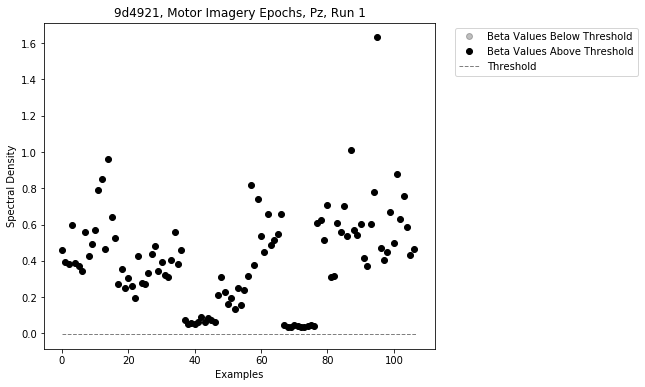

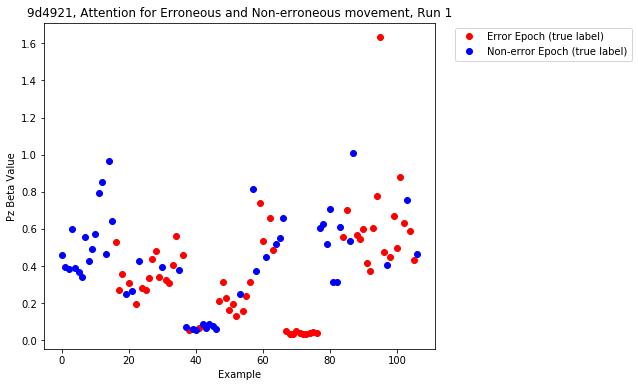

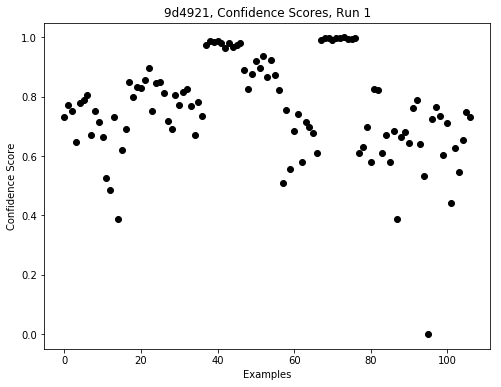

Run 2
Total number of examples: 99
Percent of correctly scored examples: 48.484848484848484%
----------------
Confusion Matrix for Error Classification (not MI)
[[43 11]
 [40  5]]
----------------


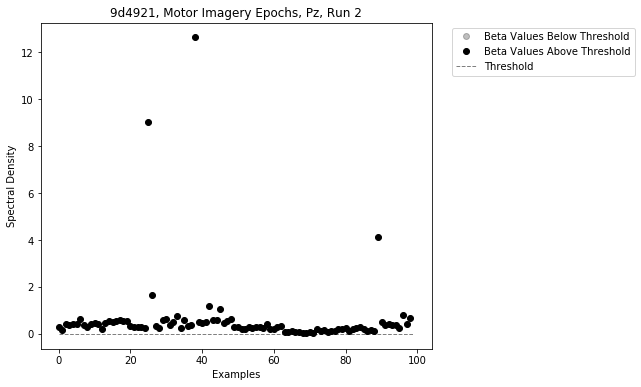

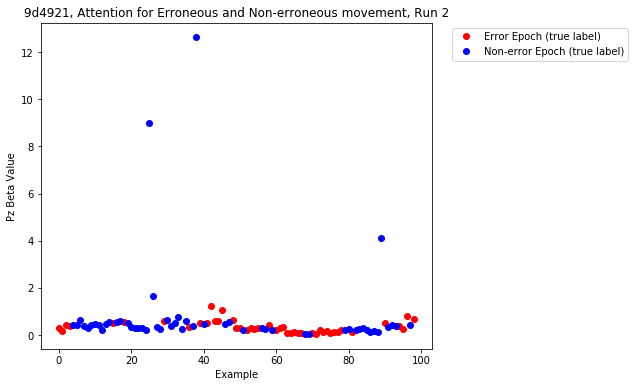

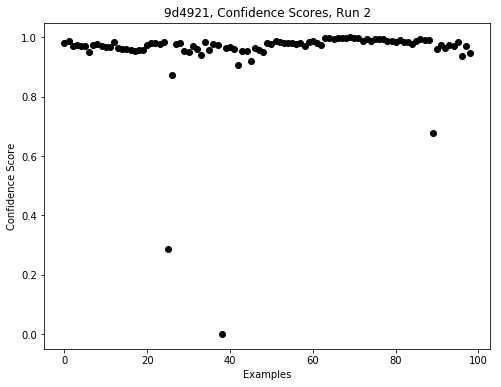

Run 3
Total number of examples: 112
Percent of correctly scored examples: 57.14285714285714%
----------------
Confusion Matrix for Error Classification (not MI)
[[47 12]
 [36 17]]
----------------


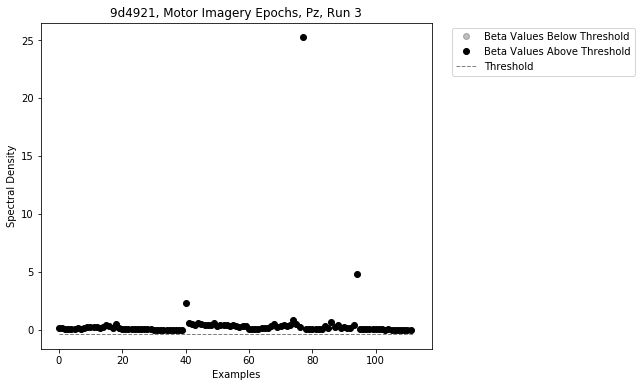

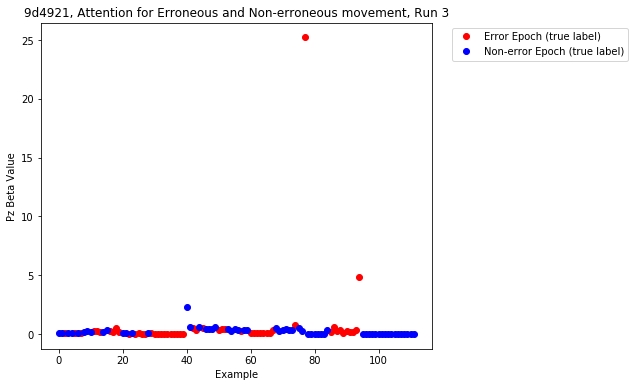

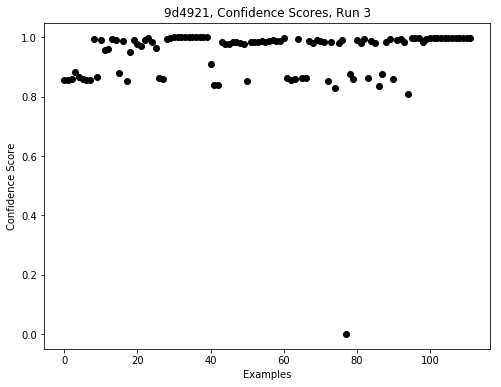

Run 4
Total number of examples: 113
Percent of correctly scored examples: 61.06194690265486%
----------------
Confusion Matrix for Error Classification (not MI)
[[69  0]
 [44  0]]
----------------


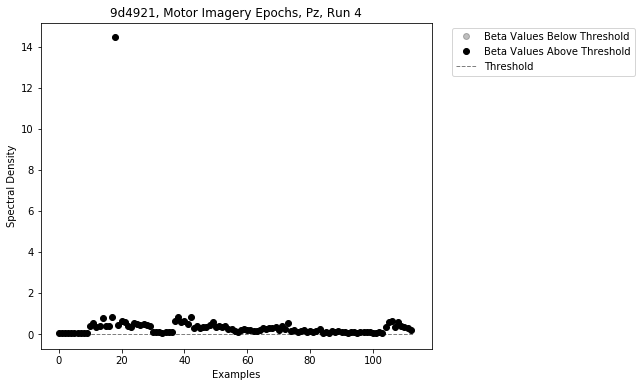

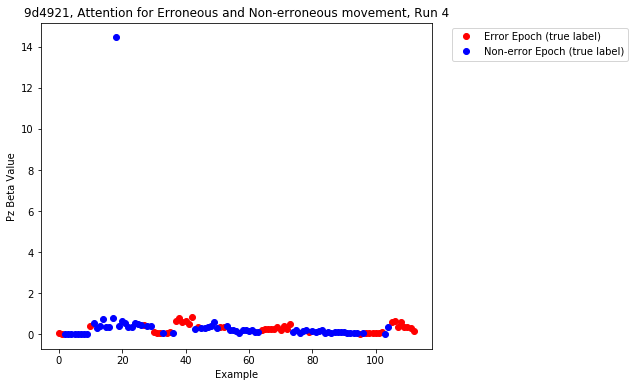

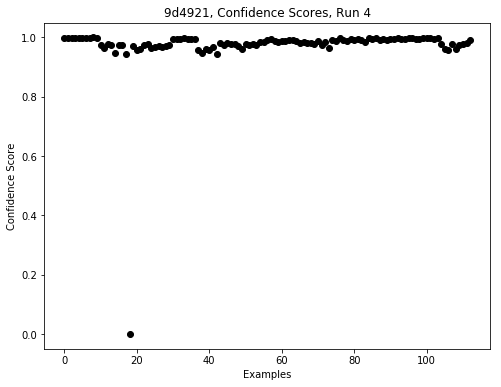

Run 5
Total number of examples: 112
Percent of correctly scored examples: 59.82142857142857%
----------------
Confusion Matrix for Error Classification (not MI)
[[51  8]
 [37 16]]
----------------


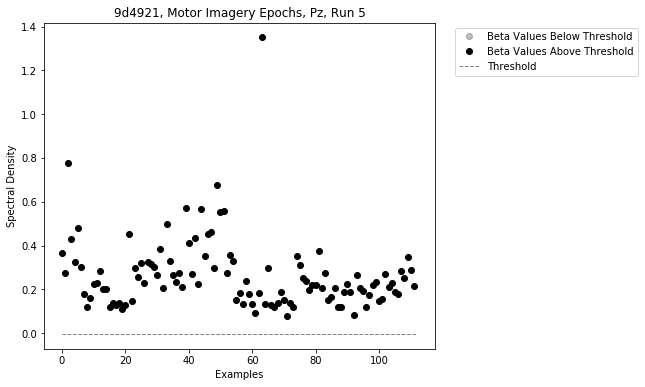

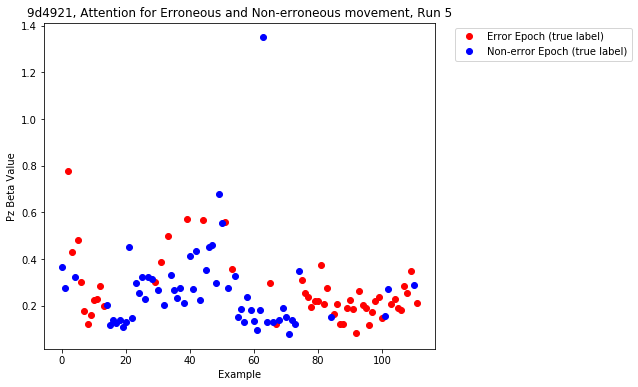

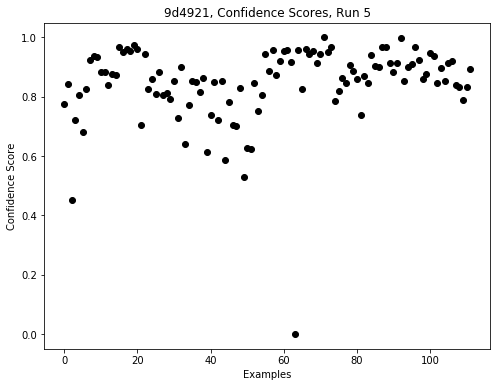

In [21]:
for runOfInt in range(1,5+1):
    print('Run ' + str(runOfInt))
    print('Total number of examples: ' + str(len(error_features_all[runOfInt])))
    print('Percent of correctly scored examples: ' + str(clf_error_all[runOfInt].score(
        error_features_all[runOfInt], TL_all[runOfInt])*100) + '%')
    print('----------------')
    print('Confusion Matrix for Error Classification (not MI)')
    print(confusion_matrix(TL_all[runOfInt], clf_error_all[runOfInt].predict(error_features_all[runOfInt])))
    print('----------------')

    # Generate Plots
    fig = plt.figure(figsize=(7,6))

    # Plot threshold
    plt.hlines(y=beta_threshold_all[runOfInt], xmin=0, xmax=len(attention_beta_all[runOfInt]['Pz']), linewidth=1, color='gray', linestyles='dashed')

    # Plot different color for those above threshold
    less_than_threshold = [i for i, val in enumerate(attention_beta_all[runOfInt]['Pz']) if val<=beta_threshold_all[runOfInt]]
    greater_than_threshold = [i for i, val in enumerate(attention_beta_all[runOfInt]['Pz']) if val>beta_threshold_all[runOfInt]]

    plt.plot(less_than_threshold, np.asarray(attention_beta_all[runOfInt]['Pz'])[less_than_threshold], 'ko', alpha=0.25)
    plt.plot(greater_than_threshold, np.asarray(attention_beta_all[runOfInt]['Pz'])[greater_than_threshold], 'ko')

    plt.xlabel('Examples')
    plt.ylabel('Spectral Density')
    plt.title(subjID + ', Motor Imagery Epochs, Pz, Run ' + str(runOfInt))
    lgd = plt.legend(['Beta Values Below Threshold','Beta Values Above Threshold','Threshold'], bbox_to_anchor=(1.04,1), loc='upper left')
    plt.show()

    fig.savefig('Figures/' + subjID + '_Pz_beta_Session' + str(session_number) + '_R' + str(runOfInt) + '.png',
               bbox_extra_artists=(lgd,), bbox_inches='tight')

    fig = plt.figure(figsize=(7,6))

    # Plot different color for whether the example was actually erroneous or not (true label)
    plot_error = [i for i, val in enumerate(TL_all[runOfInt]) if val>0.5]
    plot_no_error = [i for i, val in enumerate(TL_all[runOfInt]) if val<0.5]

    plt.plot(plot_error, np.asarray(attention_beta_all[runOfInt]['Pz'])[plot_error], 'ro')
    plt.plot(plot_no_error, np.asarray(attention_beta_all[runOfInt]['Pz'])[plot_no_error], 'bo')

    plt.xlabel('Example')
    plt.ylabel('Pz Beta Value')
    plt.title(subjID + ', Attention for Erroneous and Non-erroneous movement, Run ' + str(runOfInt))
    lgd = plt.legend(['Error Epoch (true label)','Non-error Epoch (true label)'], bbox_to_anchor=(1.04,1), loc='upper left')
    plt.show()

    fig.savefig('Figures/' + subjID + '_Pz_beta_color_Session' + str(session_number) + '_R' + str(runOfInt) + '.png',
               bbox_extra_artists=(lgd,), bbox_inches='tight')

    fig = plt.figure(figsize=(8,6))
    plt.plot(CS_all[runOfInt],'ko')
    plt.xlabel('Examples')
    plt.ylabel('Confidence Score')
    plt.title(subjID + ', Confidence Scores, Run ' + str(runOfInt))
    plt.show()

    fig.savefig('Figures/' + subjID + '_Confidence_Scores_Session' + str(session_number) + '_R' + str(runOfInt) + '.png')